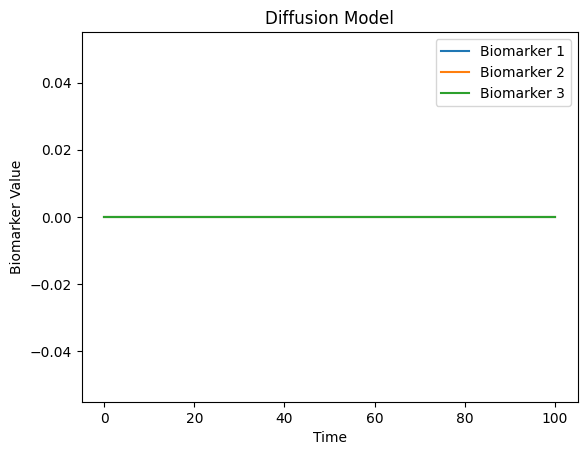

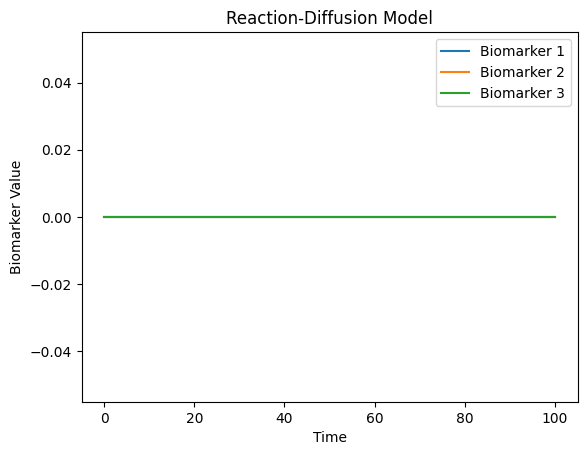

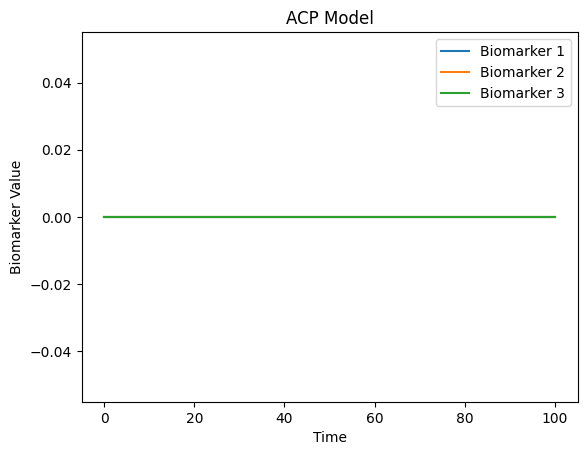

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def generate_data_diffusion(n, x0, param, tmin, tmax):
    def ode_diffusion(x, t, theta):
        return np.dot(theta, x).tolist()

    kij = param[0]
    A = param[4]

    kt_matrix = np.full([int(A.shape[0]), int(A.shape[0])], 0.1)
    Mac = np.diag(np.diag(np.full((int(A.shape[0]), int(A.shape[0])), kt_matrix)))

    kij_matrix = np.zeros([A.shape[0], A.shape[0]])
    kij_matrix[np.triu_indices(A.shape[0], 1)] = kij.reshape(int((A.shape[0] * A.shape[0] - A.shape[0]) / 2), )
    kij_matrix = (kij_matrix + kij_matrix.T)
    Min = np.multiply(kij_matrix, A)  # intake
    Mout = np.diag(np.sum(Min, axis=0))  # out-take
    M0 =  Mac + Min - Mout

    t = np.linspace(tmin, tmax, n)
    y = odeint(ode_diffusion, x0.reshape(A.shape[0], ), t, args=(M0,))
    return t, y

def generate_data_reactiondiffusion(n, x0, param, tmin, tmax):
    def ode_reactiondiffusion(x, t, theta):
        M0 = theta[0]
        R1 = theta[1]
        R2 = theta[2]
        return (np.dot(M0, x).reshape(len(x),) + (R1*x).reshape(len(x),) - (R2*x**2).reshape(len(x),)).tolist()

    kij = param[0]  # Updated for Reaction-Diffusion as a matrix
    A = param[4]

    # Create the diffusion matrix
    kt_matrix = np.full([int(A.shape[0]), int(A.shape[0])], .1)
    Mac = np.diag(np.diag(np.full((int(A.shape[0]), int(A.shape[0])), kt_matrix)))
    kij_matrix = np.zeros([A.shape[0], A.shape[0]])
    kij_matrix[np.triu_indices(A.shape[0], 1)] = kij.reshape(int((A.shape[0] * A.shape[0] - A.shape[0]) / 2), )
    kij_matrix = (kij_matrix + kij_matrix.T)
    Min = np.multiply(kij_matrix, A)  # intake
    Mout = np.diag(np.sum(Min, axis=0))  # out-take
    M0 =  Mac + Min - Mout

    # Reaction parameters
    R1 = param[1]  # Reaction scaling 1
    R2 = param[2]  # Reaction scaling 2

    M = (M0, R1, R2)
    t = np.linspace(tmin, tmax, n)
    y = odeint(ode_reactiondiffusion, x0.reshape(A.shape[0], ), t, args=(M,))
    return t, y

def generate_data_ACP(n, x0, param, tmin, tmax):
    def ode_ACP(x, t, theta):
        return np.dot(theta(x), x).tolist()

    kij = param[0]  # Updated for ACP as a matrix
    kt = param[1]
    tau1 = param[2]
    difftau12 = param[3]
    tau2 = tau1 + difftau12
    l1 = param[4]
    l2 = param[5]
    A = param[6]

    def M(x):
        kt_matrix = np.full([int(A.shape[0]), int(A.shape[0])], kt) / (1 + np.exp(l2 * (x - tau2)))
        Mac = np.diag(np.diag(np.full((int(A.shape[0]), int(A.shape[0])), kt_matrix)))

        kij_matrix = np.zeros([A.shape[0], A.shape[0]])
        kij_matrix[np.triu_indices(A.shape[0], 1)] = kij.reshape(int((A.shape[0] * A.shape[0] - A.shape[0]) / 2), )
        kij_matrix = (kij_matrix + kij_matrix.T)
        kij_matrix = kij_matrix / ((1 + np.exp(-l1 * (x - tau1))) * (1 + np.exp(l2 * (x - tau2))))

        Min = np.multiply(kij_matrix, A)
        Mout = np.diag(np.sum(Min, axis=0))
        M = Mac + Min - Mout
        return M

    t = np.linspace(tmin, tmax, n)
    y = odeint(ode_ACP, x0.reshape(A.shape[0], ), t, args=(M,))
    return t, y

def GenerateConnectome(N):
    matrix = np.random.randint(2, size=(N,N))
    matrix = matrix + matrix.T
    matrix = (matrix < 2).astype(int)
    np.fill_diagonal(matrix, 0)
    return matrix

def plot_data(t, y, title):
    plt.figure()
    for i in range(y.shape[1]):
        plt.plot(t, y[:, i], label=f'Biomarker {i+1}')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Biomarker Value')
    plt.legend()
    plt.show()

# Parameters
n_biomarkers = 3

# Diffusion model parameters
param_diffusion = []
kij_diffusion = np.random.normal(loc=0.5, scale=0.1, size=n_biomarkers)
param_diffusion.append(kij_diffusion)
param_diffusion.append([])  # Placeholder
param_diffusion.append([])  # Placeholder
param_diffusion.append([])  # Placeholder
A_diffusion = GenerateConnectome(n_biomarkers)
param_diffusion.append(A_diffusion)

# Reaction-diffusion model parameters
param_reaction_diffusion = []
kij_reaction_diffusion = np.random.normal(loc=0.5, scale=0.1, size=(n_biomarkers * (n_biomarkers - 1)) // 2)
param_reaction_diffusion.append(kij_reaction_diffusion)
param_reaction_diffusion.append(0.1)  # R1
param_reaction_diffusion.append(0.05)  # R2
A_reaction_diffusion = GenerateConnectome(n_biomarkers)
param_reaction_diffusion.append([])  # Placeholder for diffusion model compatibility
param_reaction_diffusion.append(A_reaction_diffusion)

# ACP model parameters
param_acp = []
kij_acp = np.random.normal(loc=0.5, scale=0.1, size=(n_biomarkers * (n_biomarkers - 1)) // 2)
param_acp.append(kij_acp)
param_acp.append(0.1)  # kt
param_acp.append(1.0)  # tau1
param_acp.append(0.5)  # difftau12
param_acp.append(3.0)  # l1
param_acp.append(3.0)  # l2
A_acp = GenerateConnectome(n_biomarkers)
param_acp.append(A_acp)

# Initial conditions
x0 = np.zeros(n_biomarkers)

# Generate data and plot for diffusion model
t, y = generate_data_diffusion(n=100, x0=x0, param=param_diffusion, tmin=0, tmax=100)
plot_data(t, y, title="Diffusion Model")

# Generate data and plot for reaction-diffusion model
t, y = generate_data_reactiondiffusion(n=100, x0=x0, param=param_reaction_diffusion, tmin=0, tmax=100)
plot_data(t, y, title="Reaction-Diffusion Model")

# Generate data and plot for ACP model
t, y = generate_data_ACP(n=100, x0=x0, param=param_acp, tmin=0, tmax=100)
plot_data(t, y, title="ACP Model")
